***<u>importing required libraries</u>***

In [32]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

**The format of our file is image and caption separated by a newline (“\n”) i.e it consists of the name of the image followed by a space and the description of the image in CSV format. Here we need to map the image to its descriptions by storing them in a dictionary.**

In [2]:
captions_path = 'path'
images_directory = 'path\'
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

***<u>Cleaning the text</u>***


**One of the main steps in NLP is to remove noise so that the machine can detect the patterns easily in the text. Noise will be present in the form of special characters such as hashtags, punctuation and numbers. All of which are difficult for computers to understand if they are present in the text. So we need to remove these for better results. Additionally you can also remove stop words and perform Stemming and Lemmatization by using NLTK library.**


In [3]:
import re
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

***<u>Cleaning the captions</u>***

**We further process the captions by adding start and end tokens to define the sentence boundaries.**

In [4]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

***<u>Load some images with captions</u>***

**Here we need to map the images in the training set to their corresponding descriptions which are present in our descriptions variable. Create a list of names of all training images and then create an empty dictionary and map the images to their descriptions using image name as key and a list of descriptions as its value. while mapping the descriptions add unique words at the beginning and end to identify the start and end of the sentence.**

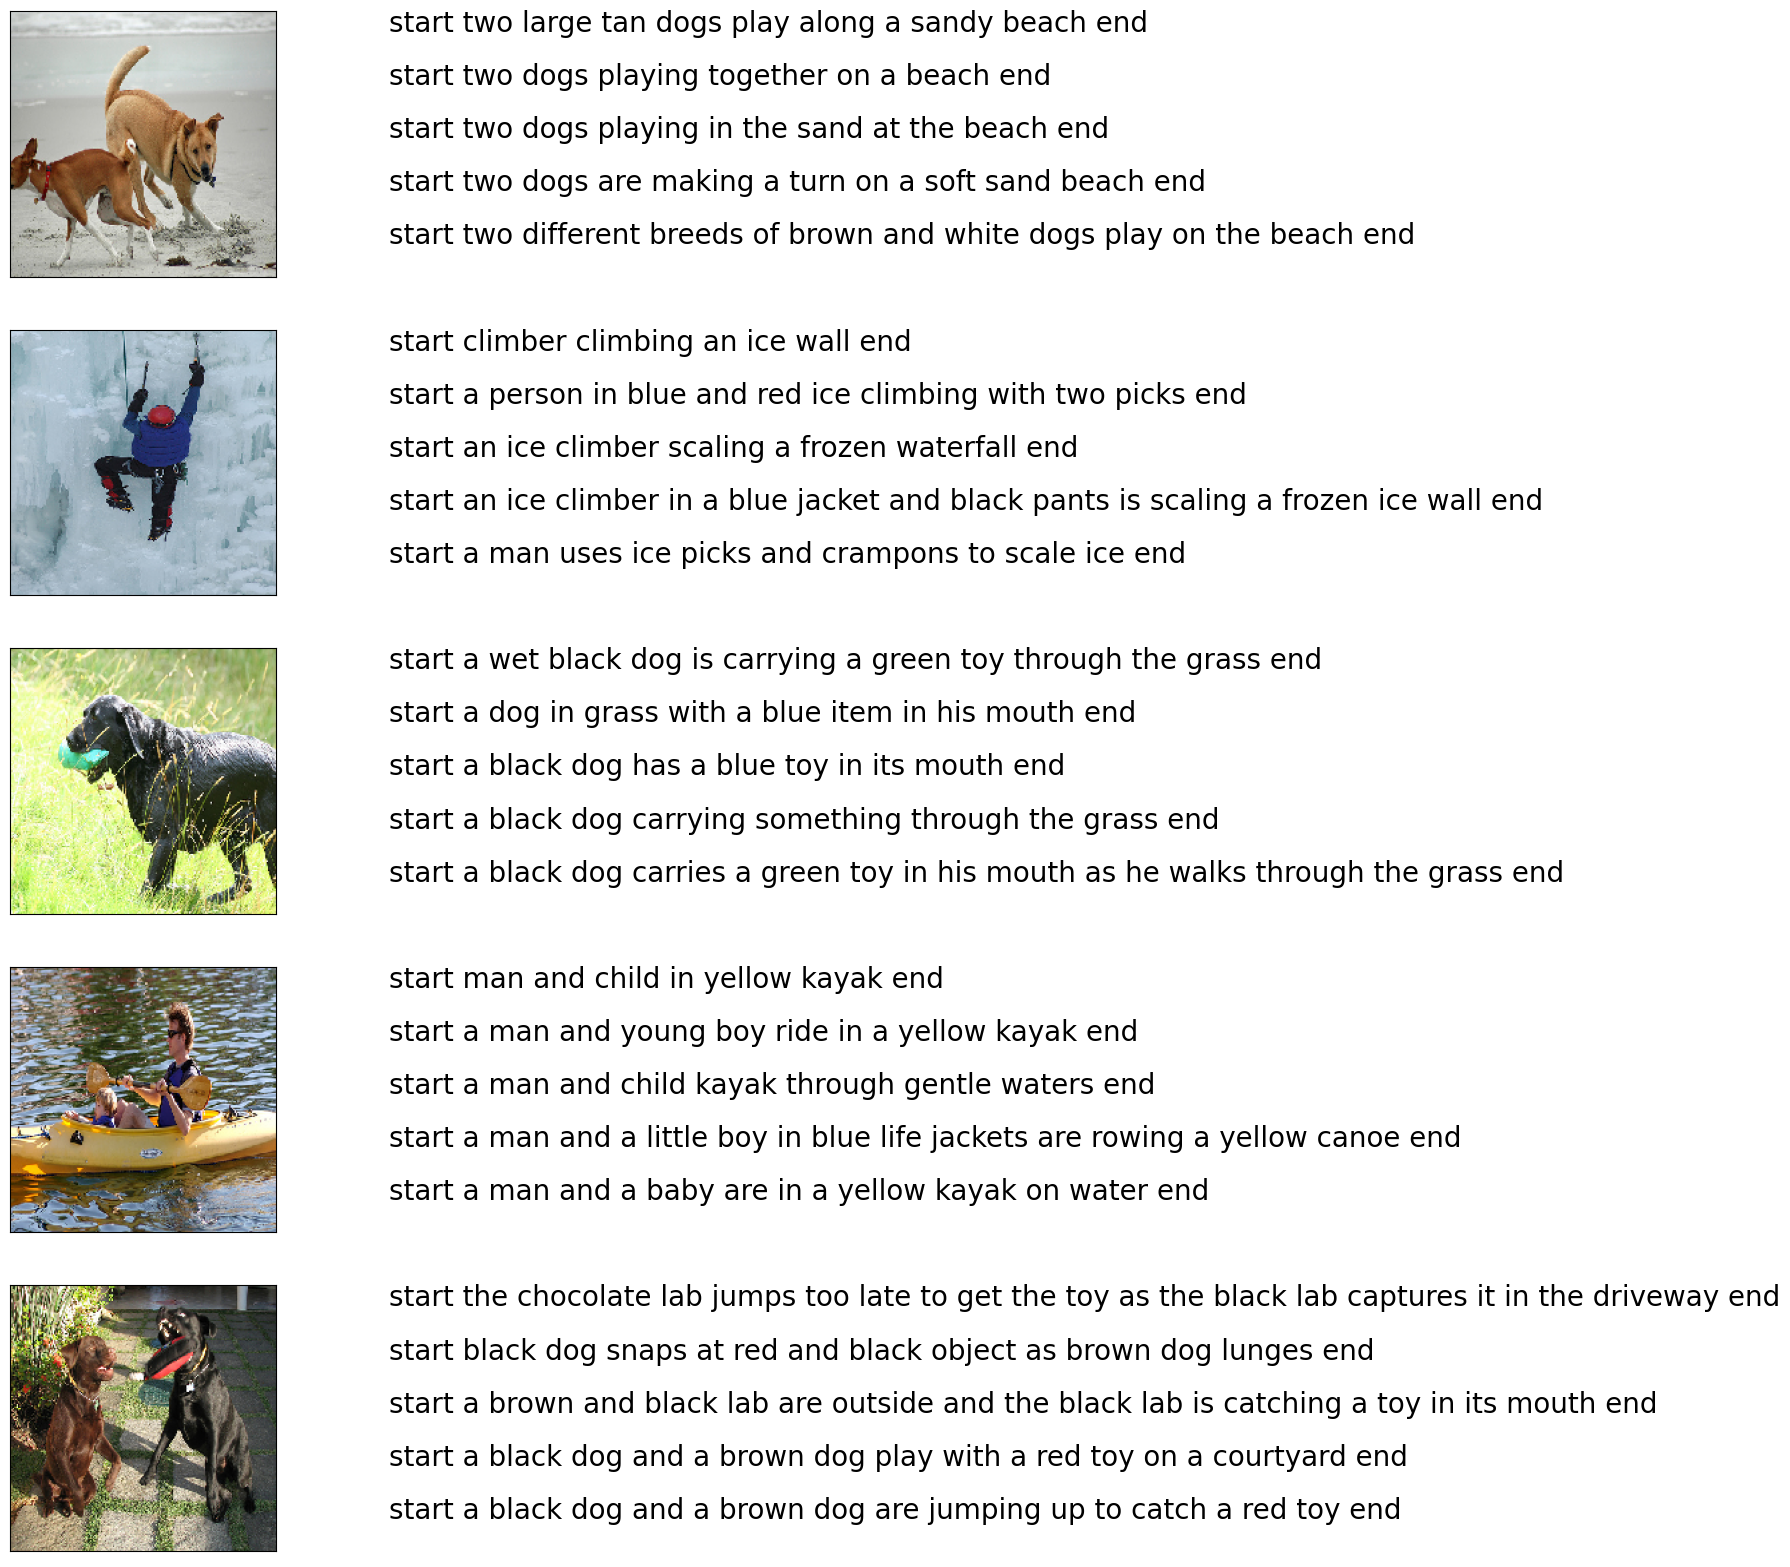

In [5]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)

***<u>Exploring the Caption Length Distribution</u>***

**We analyze the length of captions to determine an optimal sequence length.**

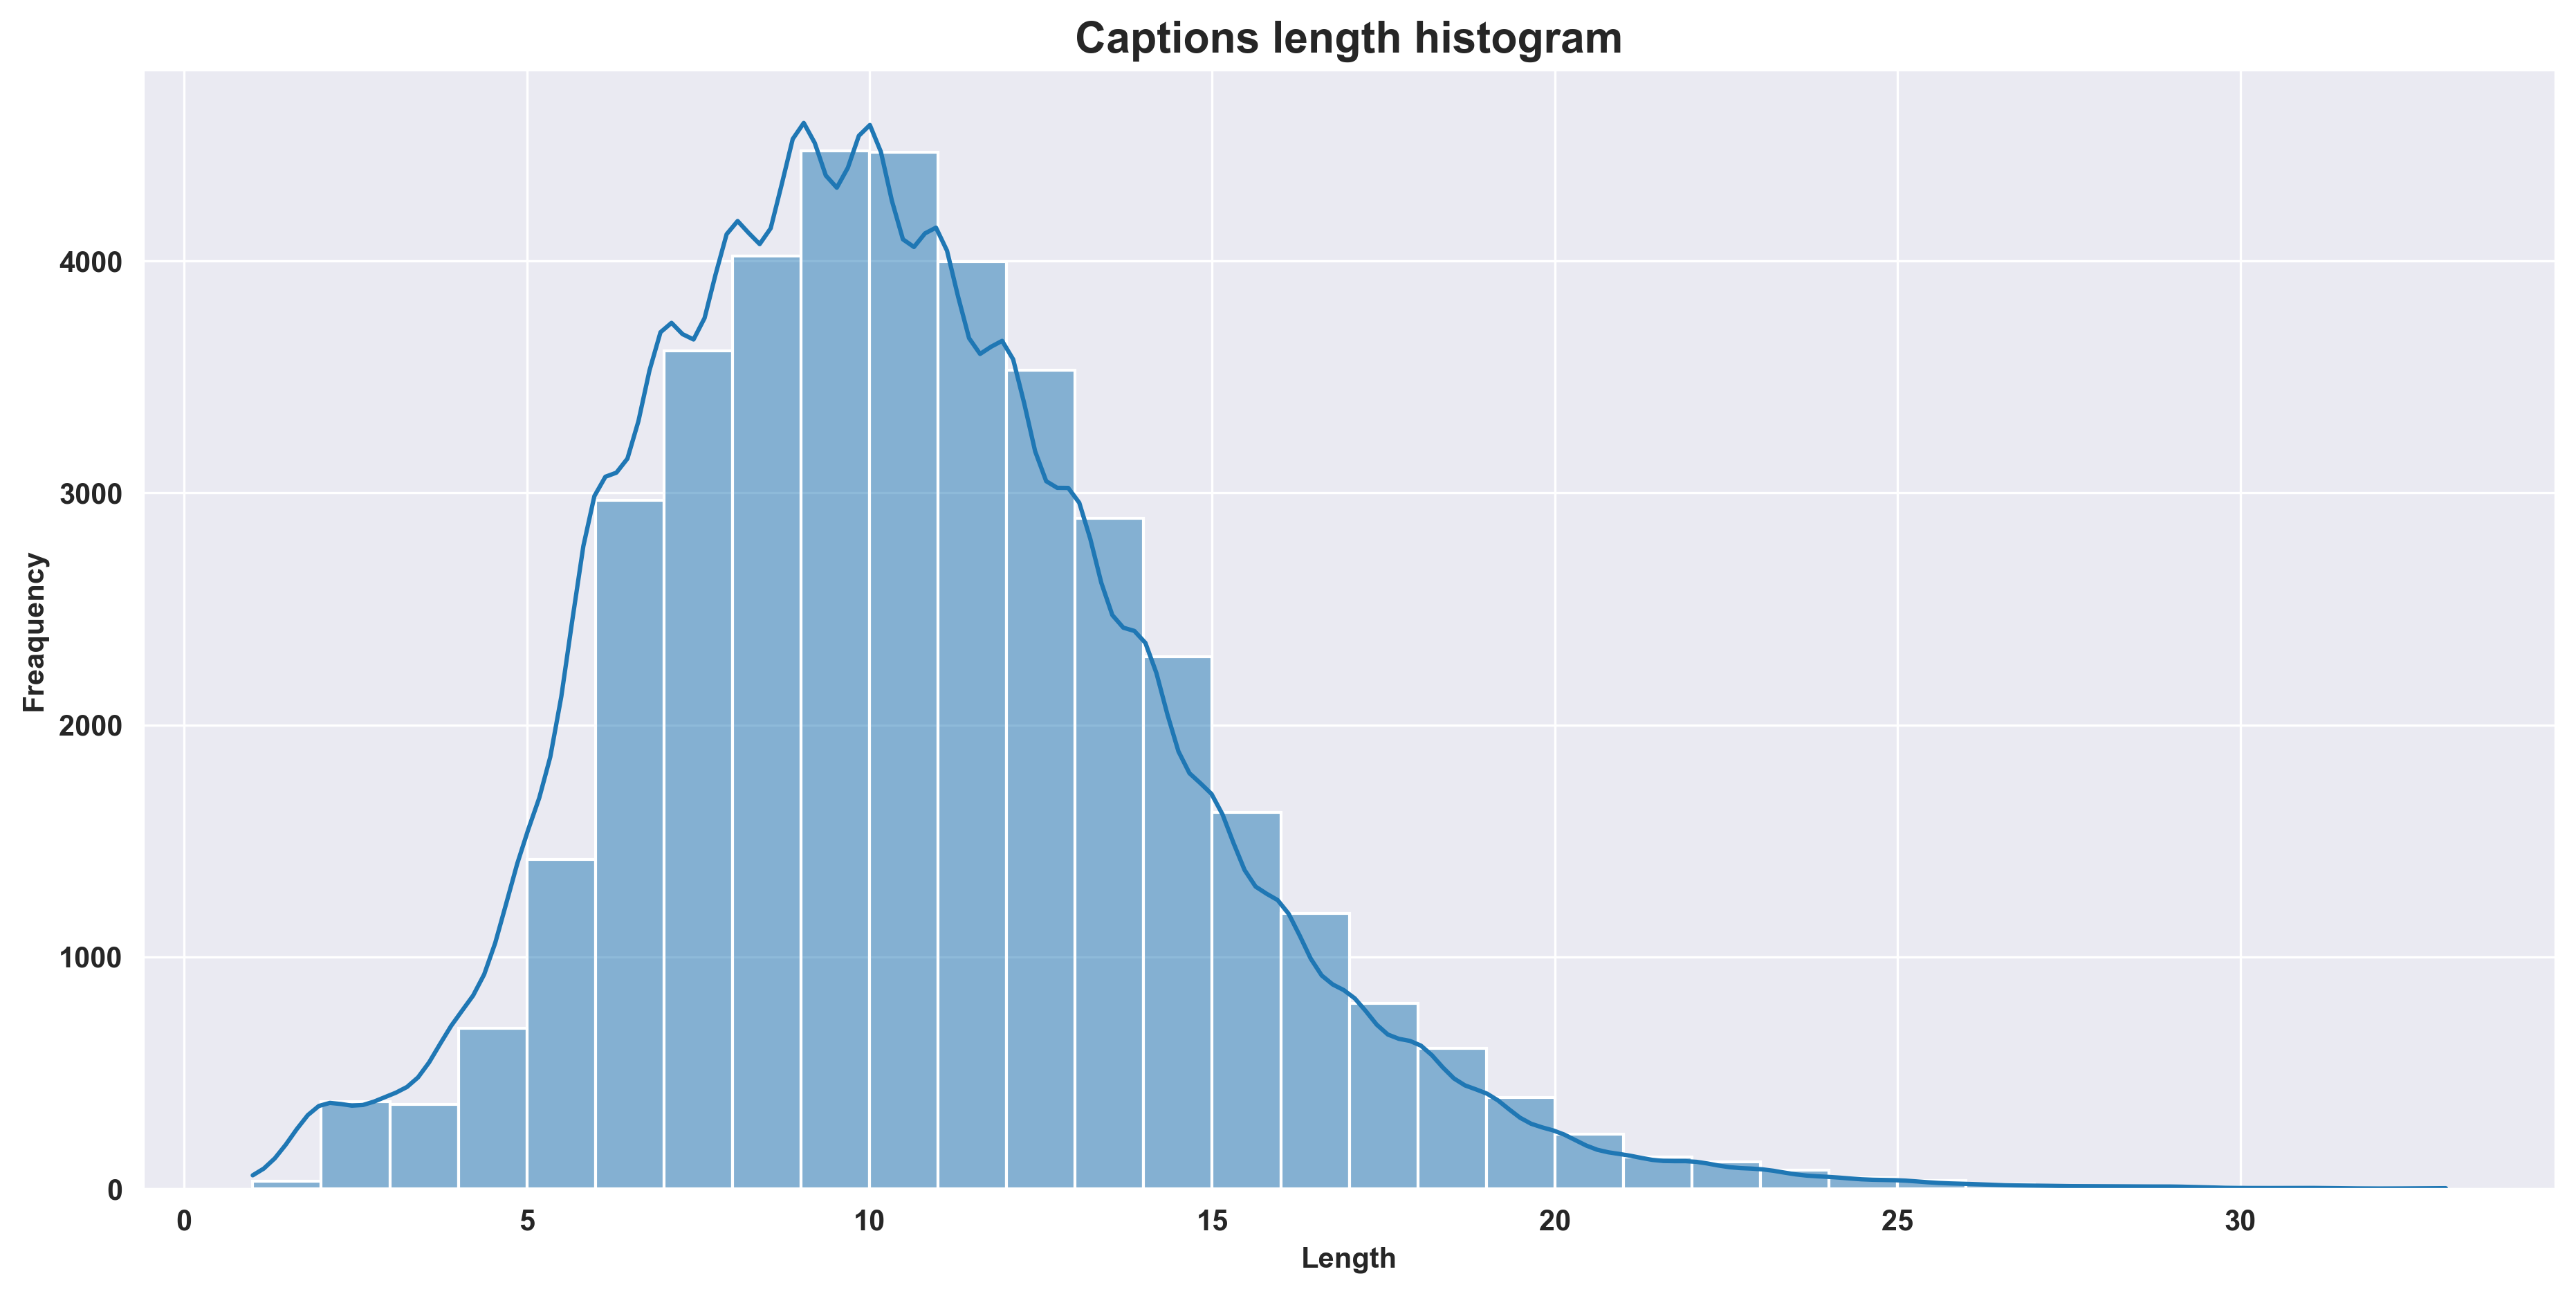

In [6]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

***<u>Tokenizing the vocabulary</u>***

**We will use Keras Tokenizer to convert text data into numerical sequences.**

In [7]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

***<u>Splitting the data into train, validation and test sets</u>***

**We divide our dataset into training, validation and testing subsets.**

In [8]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1022454428_b6b660a67b.jpg\tstart a couple and an infant end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

***<u>Extract the feature vector from all images</u>***

**Now we will give an image as an input to our model but unlike humans, machines cannot understand the image by seeing them. So we need to convert the image into an encoding so that the machine can understand the patterns in it. For this task, I'm using transfer learning i.e, we use a pre-trained model that has been already trained on large datasets and extract the features from these models and use them for our work. Here I'm using the InceptionV3 model which has been trained on Imagenet dataset that had 1000 different classes to classify. We can directly import this model from Keras.applications module. We need to remove the last classification layer to get the (2048, ) dimensional feature vector from InceptionV3 model.**

In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

***<u>Extracting Image Features for Training, Validation and Testing</u>***

**To train our Image Caption Generator, we need to extract feature vectors from images using the pre-trained InceptionV3 model. These features will serve as inputs to our captioning model. We store the extracted features in dictionaries corresponding to training, validation, and testing datasets.**

In [10]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

***<u>Creating a Data Generator for Model Training</u>***

**Since training a deep learning model requires handling large datasets, we implement a data generator to yield batches of image features and corresponding tokenized captions. This approach improves memory efficiency by processing data dynamically rather than loading everything into memory at once.**

In [11]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)


max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

cnn_output_dim = inception_v3_model.output_shape[1] # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

***<u>Building the Image Captioning Model<u>***

**We define the architecture of our Image Captioning model using the Keras Functional API. The model consists of:**

**Image Feature Extractor (CNN Output Processing)**: The input image feature vector (2048-dimensional) is normalized using Batch Normalization. A Dense layer transforms it into a 256-dimensional vector to match the LSTM output size.

**Text Sequence Processor (LSTM-based Decoder)**: The tokenized captions are passed through an Embedding layer, mapping words to dense vector representations. An LSTM layer processes the embedded sequence to generate a feature representation.

**Decoder and Final Prediction**: The processed image and text features are combined using an addition operation. A Dense layer refines the representation before making the final word prediction using a softmax activation function**

In [12]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, 2048)        8192        ['Features_Input[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['batch_normalizat

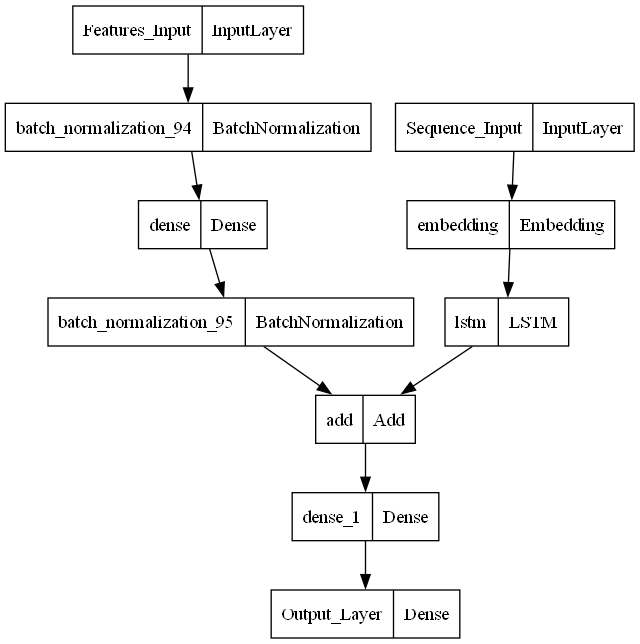

In [13]:
plot_model(caption_model)

***<u>Training the Model with Early Stopping and Learning Rate Scheduling</u>***

**We train the model using the Adam optimizer and categorical cross-entropy loss while implementing early stopping to prevent overfitting. A learning rate scheduler is applied to gradually decrease the learning rate over epochs, ensuring stable convergence. The model is trained for up to 15 epochs with validation monitoring.**

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 [==============================] - 695s 5s/step - loss: 4.5579 - val_loss: 3.7640 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 541s 4s/step - loss: 3.3053 - val_loss: 3.3542 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 570s 4s/step - loss: 2.9119 - val_loss: 3.2476 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 564s 4s/step - loss: 2.6887 - val_loss: 3.2147 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 582s 5s/step - loss: 2.5534 - val_loss: 3.2101 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 521s 4s/step - loss: 2.4702 - val_loss: 3.2105 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 570s 4s/step - loss: 2.4215 - val_loss: 3.2121 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 618s 5s/step - loss: 2.3915 - val_loss: 3.2163 - lr: 8.2297e-05


***<u>Visualizing Training and Validation Loss</u>***

**We plot the training and validation loss over epochs to analyze the model's learning process. This helps in identifying overfitting and assessing model performance improvements across iterations.**

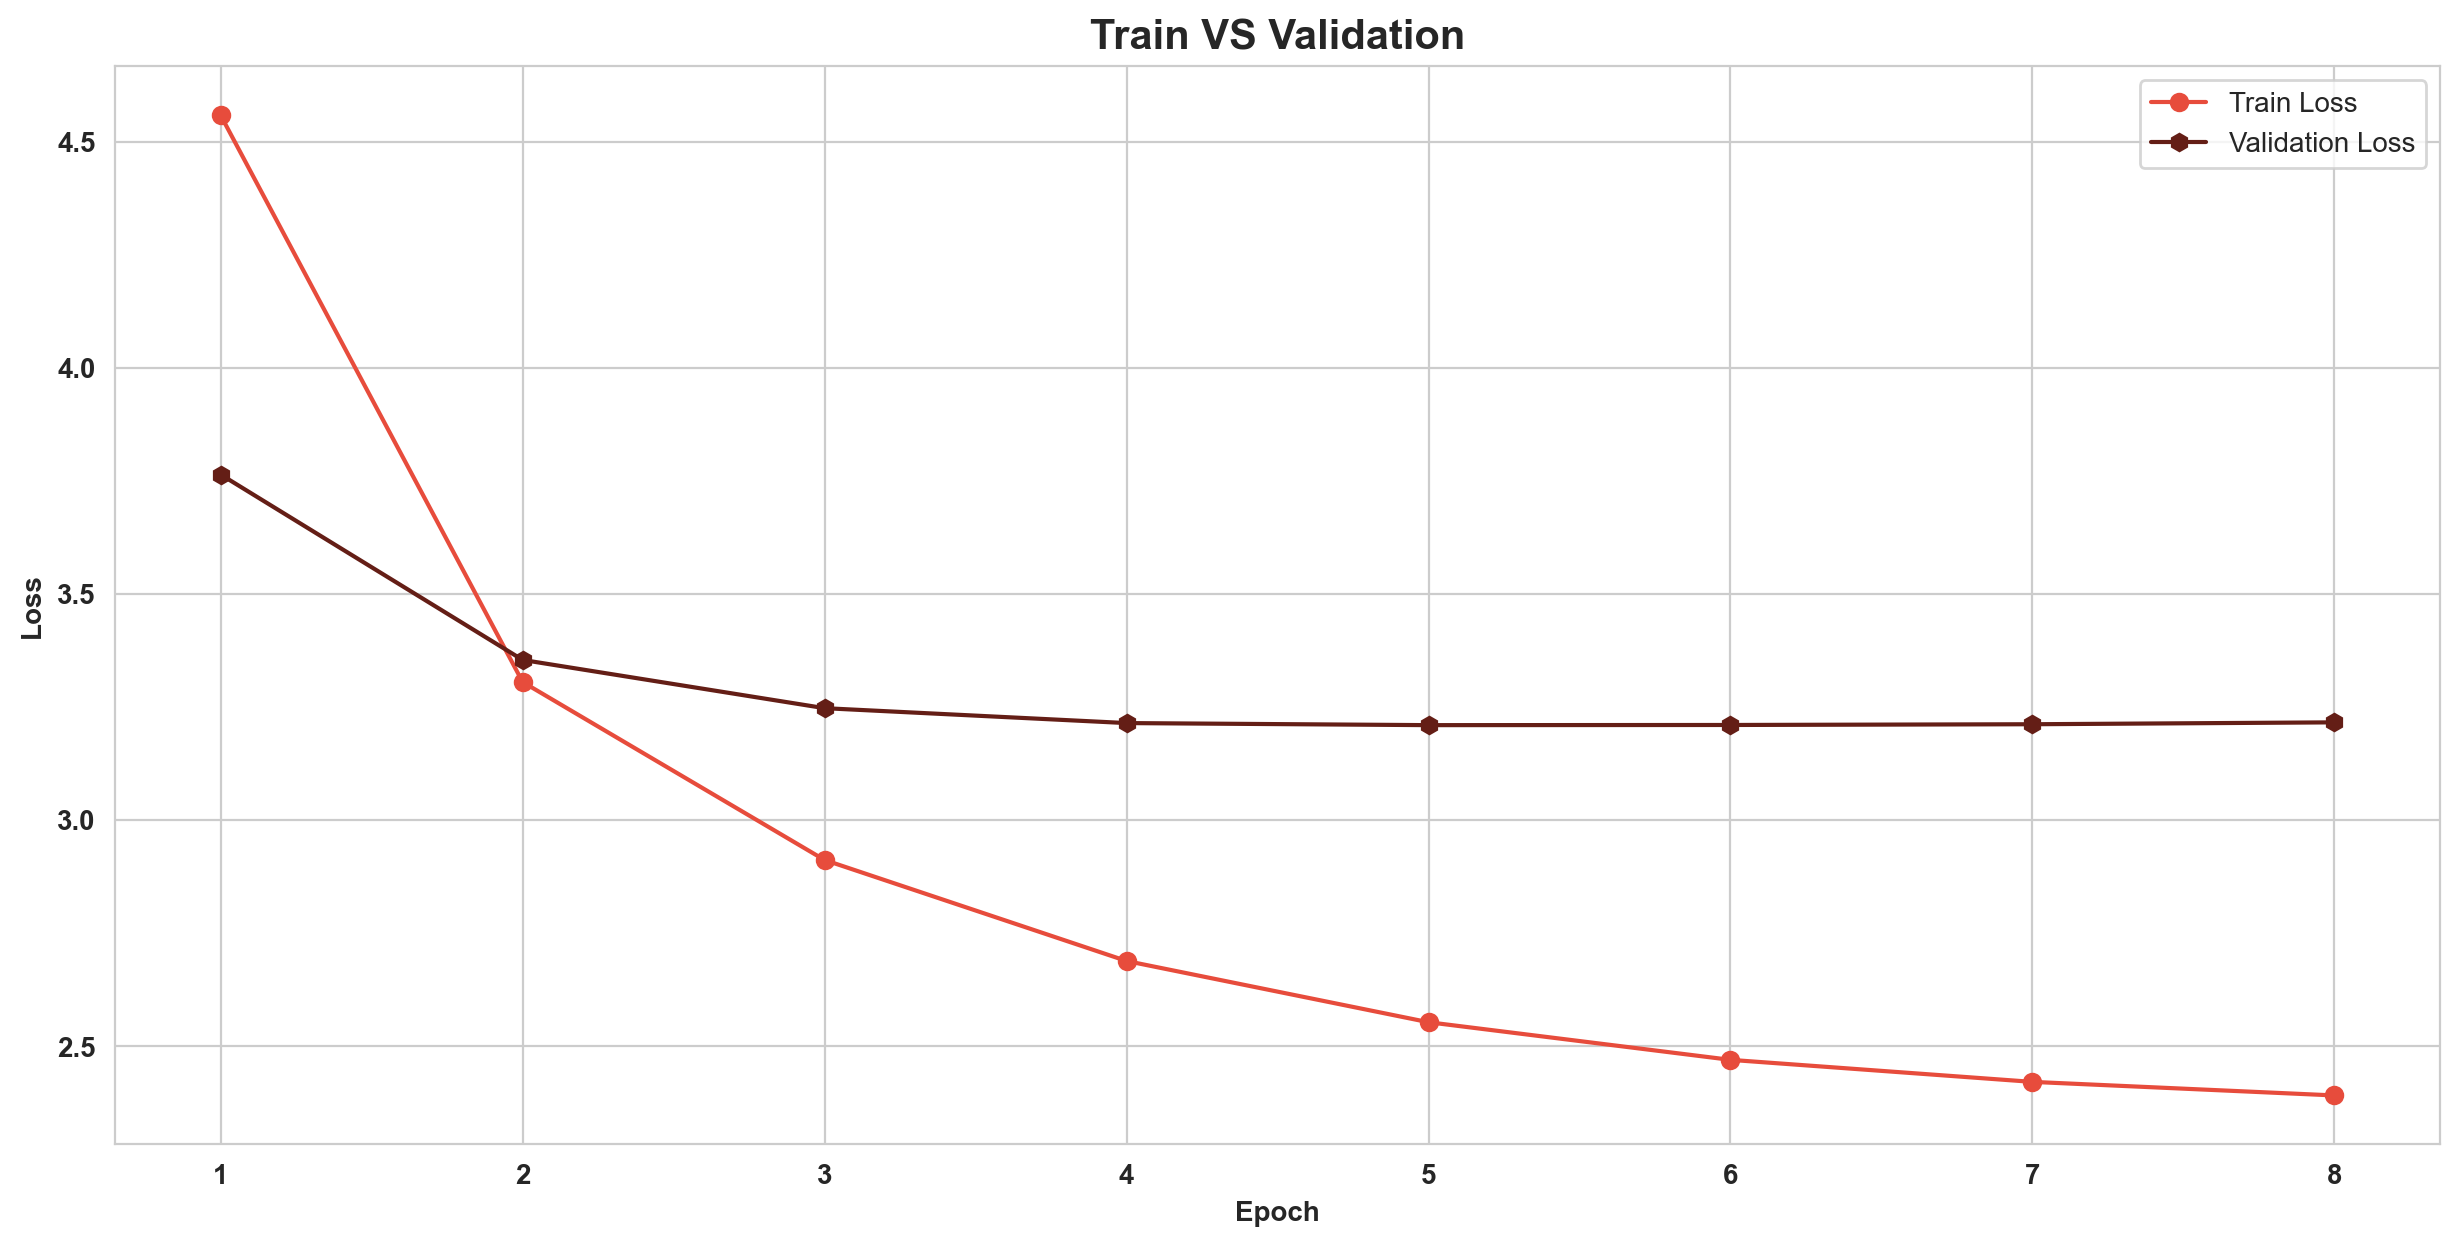

In [15]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

***<u>Generating Captions Using Greedy Search</u>***

**We implement a greedy search algorithm to generate captions by predicting one word at a time. The model selects the word with the highest probability at each step until the end token is reached.**

In [47]:
def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_caption_length).reshape((1,max_caption_length))
        preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), seq], verbose=0)
        idx = np.argmax(preds)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    # --- CLEAN UP HERE ---
    out = in_text.replace('start ', '').replace(' end', '').strip().lower()
    return out


***<u>Generating Captions Using Beam Search</u>***

**We implement beam search to generate captions by exploring multiple possible sequences at each step. This method selects the top K probable sequences.**

In [48]:
def beam_search_generator(image_features, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    beams = [[start, 0.0]]
    for _ in range(max_caption_length):
        candidates = []
        for seq, score in beams:
            padded = pad_sequences([seq], maxlen=max_caption_length).reshape((1,max_caption_length))
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), padded], verbose=0)[0]
            for w in np.argsort(preds)[-K_beams:]:
                new_seq = seq + [w]
                new_score = score + (np.log(preds[w]) if log else preds[w])
                candidates.append([new_seq, new_score])
        beams = sorted(candidates, key=lambda x: x[1])[-K_beams:]

    # take best beam
    best_seq = beams[-1][0]
    words = [tokenizer.index_word[i] for i in best_seq if i in tokenizer.index_word]
    # drop the first 'start' and everything after 'end'
    if words and words[0] == 'start':
        words = words[1:]
    if 'end' in words:
        words = words[:words.index('end')]

    # --- CLEAN UP HERE ---
    out = ' '.join(words).strip().lower()
    return out


***<u>BLEU Score</u>***

**It Computes the BLEU (Bilingual Evaluation Understudy) score a metric for evaluating the quality of text translations by comparing them to one or more reference translations.**

In [49]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

def BLEU_score(actual, greedy, beam_search):
    # Tokenize
    references   = [[ref.split() for ref in actual]]   # one image’s refs
    greedy_tok   = [greedy[0].split()]                 # greedy hypothesis
    beam_tok     = [beam_search[0].split()]            # beam   hypothesis

    # Greedy: BLEU‑1 and BLEU‑2
    b1_g = corpus_bleu(references, greedy_tok, weights=(1,0,0,0),    smoothing_function=smoothie)
    b2_g = corpus_bleu(references, greedy_tok, weights=(0.5,0.5,0,0),smoothing_function=smoothie)

    # Beam:   BLEU‑1 and BLEU‑2
    b1_b = corpus_bleu(references, beam_tok,   weights=(1,0,0,0),    smoothing_function=smoothie)
    b2_b = corpus_bleu(references, beam_tok,   weights=(0.5,0.5,0,0),smoothing_function=smoothie)

    return [
        f'Greedy BLEU-1: {b1_g:.4f}',
        f'Greedy BLEU-2: {b2_g:.4f}',
        f'Greedy Caption : {greedy[0]}',
        f'Beam   BLEU-1: {b1_b:.4f}',
        f'Beam   BLEU-2: {b2_b:.4f}',
        f'Beam   Caption : {beam_search[0]}'
    ]


***<u>Generating Captions for Test Images</u>***

**We generate captions for all test images using the greedy search method. A progress bar is used to track the generation process efficiently.**

In [20]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

***<u>Visualizing Caption Generation Results</u>***

**We randomly select images from the test set and display them alongside their actual captions, greedy search-generated captions and beam search-generated captions. The BLEU score evaluator is used to assess the quality of the generated captions.**

In [50]:
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.strip().split('\t')
    # 1) remove your special tokens
    caption = caption.replace("start ", "").replace(" end", "")
    # 2) lowercase (so case‑mismatches can’t zero out your BLEU)
    caption = caption.lower()
    # 3) store
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)


In [53]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    valid_keys = list(set(data.keys()) & set(greedy_caps.keys()) & set(test_image_features.keys()))
    if len(valid_keys) < num_of_images:
        print(f"⚠️ Only {len(valid_keys)} valid images available. Showing those instead of {num_of_images}.")
        num_of_images = len(valid_keys)
    images = np.random.choice(valid_keys, size=num_of_images, replace=False)

    count = 1
    fig = plt.figure(figsize=(6, 5 * num_of_images))

    for filename in images:
        # Clean & lowercase your reference captions
        actual_cap = data[filename]
        actual_cap = [
            cap.replace("start ", "")
               .replace(" end", "")
               .lower()
            for cap in actual_cap
        ]

        # Clean & lowercase your predictions too
        greedy_cap = greedy_caps[filename]\
                        .replace("start ", "")\
                        .replace(" end", "")\
                        .lower()

        beamS_cap = beamS_generator(test_image_features[filename])\
                        .replace("start ", "")\
                        .replace(" end", "")\
                        .lower()

        # Now evaluator (your BLEU_score) will split on spaces and find real overlaps
        caps_with_score = evaluator(
            actual_cap,
            [greedy_cap] * len(actual_cap),
            [beamS_cap] * len(actual_cap)
        )

        # — rest of your plotting code stays the same —
        image_load = load_img(images_directory + filename, target_size=(199, 199, 3))
        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0, i, text, fontsize=10)
        count += 1

    plt.show()


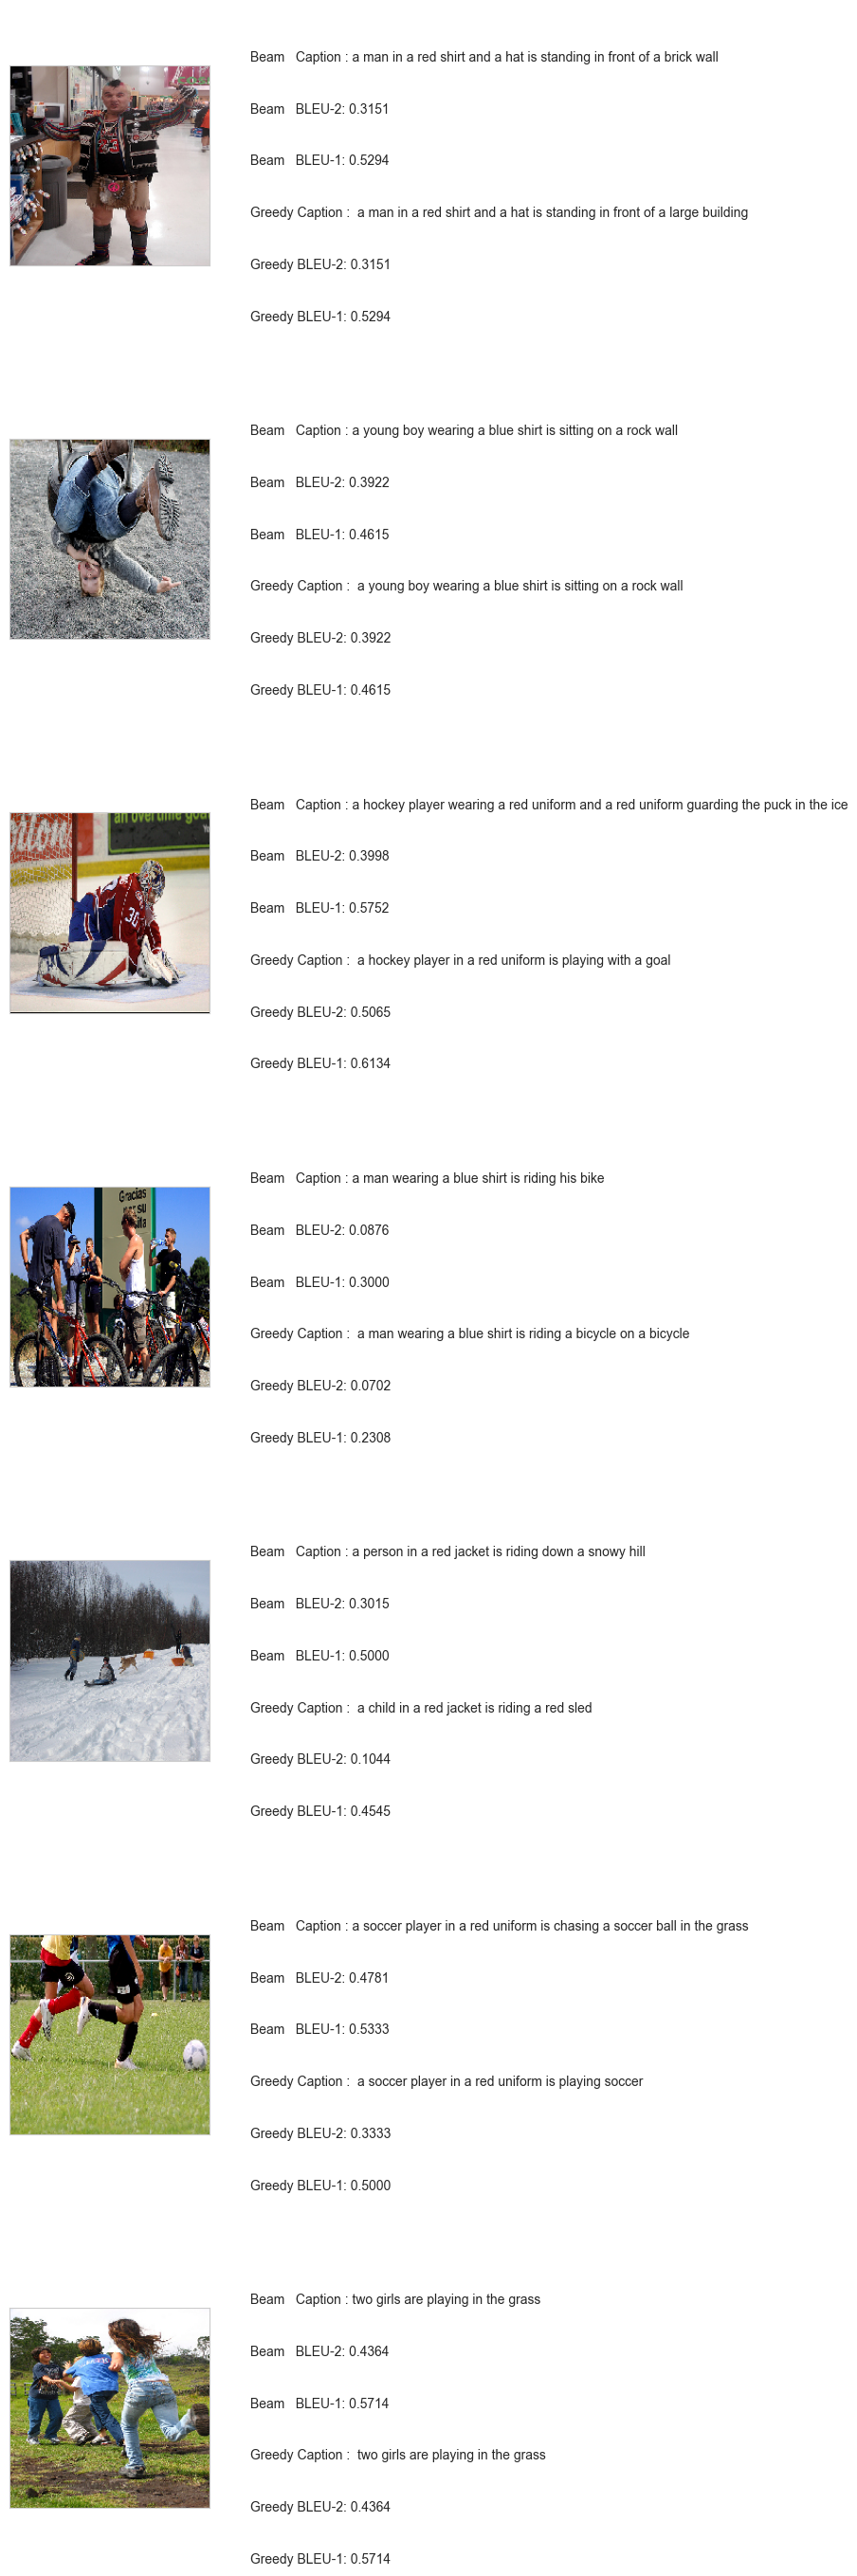

In [66]:
visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)


In [40]:
caption_model.save("caption_model.h5")


In [57]:
os.makedirs("model", exist_ok=True)

In [58]:
import pickle
with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)